In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Working with genomic ranges in modality

A common pattern when analysing methylation datasets is to perform a series of operations over specified genomic regions. [```modality```](https://modality-docs.biomodal.com/) has extensive support for working with genomic ranges via ```pyranges``` objects from the [```PyRanges```](https://pyranges.readthedocs.io/en/latest/index.html) package. In this notebook we showcase some of the working patterns and analyses that are enabled by [```modality```](https://modality-docs.biomodal.com/) when working with genomic ranges.

## Load data

For the purposes of this demo we can use a duet +modC dataset of Genome in a bottle (GIAB) samples. The data are publicly available and can be loaded using the [```load_biomodal_dataset()```](https://modality-docs.biomodal.com/modality.html#modality.datasets.load_biomodal_dataset) function from the ```modality.datasets``` module. This will pull the dataset and load it in to our session as a ContigDataset object.

In [2]:
from modality.datasets import load_biomodal_dataset

ds = load_biomodal_dataset("giab")

We will restrict to a single trio in the dataset here for the purposes of the demonstration. Once we have subset the dataset we use ```assign_fractions``` method of the [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset) to calculate methylation fractions.

In [3]:
sample_selection = ds["family"].values == "Ashkenazi Jewish"
ds = ds.sel(sample_id=sample_selection).copy()

ds.assign_fractions(
    numerators="num_modc",
    denominator="num_total_c",
    min_coverage=10,
    inplace=True,
)

## Annotation via intervals
Often we will want to overlay some annotation from external sources onto the genomic regions captured in the [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset). ```modality``` provides a series of built-in functions to extract genomic annotations from [```UCSC```](https://hgdownload.soe.ucsc.edu/downloads.html) and [```GENECODE```](https://www.gencodegenes.org/). These functions are availble via the [```modality.annotation```](https://modality-docs.biomodal.com/modality.html#module-modality.annotation) module.

#### Using built-in functions for retrieving annotation

In [4]:
from modality.annotation import (
    get_cpg_islands,
    get_cpg_shores,
    get_cpg_shelves,
    get_exons,
    get_five_prime_utrs,
)

We can wrap multiple ```get_*``` functions into lists or dictionaries and then use these for downstream analysis:

In [5]:
cpg_annotations = [
    get_cpg_islands(contigs=ds.attrs["contigs"]),
    get_cpg_shelves(contigs=ds.attrs["contigs"]),
    get_cpg_shores(contigs=ds.attrs["contigs"]),
]

For example, the first item in the ```cpg_annotations``` list here is a ```pyranges``` object of CpG islands:

In [6]:
cpg_islands = cpg_annotations[0]
cpg_islands

+-----------+-----------+--------------+-----------+-----------+-------+
| Index     | Bin       | Chromosome   | Start     | End       | +8    |
| (int64)   | (int64)   | (category)   | (int64)   | (int64)   | ...   |
|-----------+-----------+--------------+-----------+-----------+-------|
| 9         | 585       | chr1         | 28735     | 29737     | ...   |
| 10        | 586       | chr1         | 135124    | 135563    | ...   |
| 11        | 586       | chr1         | 199251    | 200121    | ...   |
| 12        | 587       | chr1         | 368792    | 370063    | ...   |
| ...       | ...       | ...          | ...       | ...       | ...   |
| 190       | 786       | chrY         | 26409388  | 26409785  | ...   |
| 191       | 788       | chrY         | 26627168  | 26627397  | ...   |
| 192       | 1020      | chrY         | 57067645  | 57068034  | ...   |
| 193       | 1021      | chrY         | 57203115  | 57203423  | ...   |
+-----------+-----------+--------------+-----------+-----------+-------+
Unstranded PyRanges object has 27,949 rows and 13 columns from 24 chromosomes.
For printing, the PyRanges was sorted on Chromosome.
8 hidden columns: Length, Cpgnum, Gcnum, Percpg, Pergc, Obsexp, Type, Ranges_ID

## Providing your own set of genomic ranges

You can also specify you own set of genomic ranges, either by loading in a file, for example a bedfile using [```pyranges.read_bed```](https://pyranges.readthedocs.io/en/latest/autoapi/pyranges/readers/index.html#pyranges.readers.read_bed) or building a ranges object:

In [7]:
import pyranges as pr

custom_ranges = pr.PyRanges(
    chromosomes=["chr1", "chr1", "chr1"],
    starts=[28735, 135124, 199251],
    ends=[29737, 135563, 200121],
)
custom_ranges

+--------------+-----------+-----------+
| Chromosome   |     Start |       End |
| (category)   |   (int64) |   (int64) |
|--------------+-----------+-----------|
| chr1         |     28735 |     29737 |
| chr1         |    135124 |    135563 |
| chr1         |    199251 |    200121 |
+--------------+-----------+-----------+
Unstranded PyRanges object has 3 rows and 3 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

## Computing over genomic ranges

Once you have a set of genomic ranges of interest we can use the ```reduce_byranges()``` method of the [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset), to summarise methylation information across these ranges. In a bit more detail:

Broadly, from a set of N (chr, start, stop) intervals, applied to a dataset of C (contexts) x S (samples) we transform to an array of (start_ix, stop_ix) windows. When the set of intervals is applied, we select a function ([```numpy.mean```](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) or [```numpy.sum```](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)) that is applied to rows of the selected variable, and applied across axis 0, ie summarizing all values in the window.

***Please note: currently we only support mean or sum reduction methods. We hope to address this in future releases***

In [8]:
reduced_ds = ds.reduce_byranges(
    ranges=cpg_annotations,
    var="num_total_c",
)

This method returns an [```xarray.Dataset```](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with reduced variables now computed over the ranges we specified.

In [9]:
reduced_ds

<xarray.Dataset>
Dimensions:                (ranges: 137687, sample_id: 6)
Coordinates:
    contig                 (ranges) <U5 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY'
    start                  (ranges) int64 28735 135124 ... 57201115 57203423
    end                    (ranges) int64 29737 135563 ... 57203115 57205423
    range_id               (ranges) int64 0 1 2 3 ... 137684 137685 137686
    num_contexts           (ranges) int64 222 60 208 198 168 58 ... 36 0 0 0 0
    range_length           (ranges) int64 1002 439 870 1271 ... 2000 2000 2000
    NA_id                  (sample_id) object 'NA24385' 'NA24149' ... 'NA24143'
    giab_id                (sample_id) object 'HG002' 'HG003' ... 'HG004'
  * sample_id              (sample_id) <U22 'CEG1530-EL01-A1200-004' ... 'CEG...
Dimensions without coordinates: ranges
Data variables:
    num_total_c_sum        (ranges, sample_id) uint64 dask.array<chunksize=(34422, 2), meta=np.ndarray>
    num_total_c_mean       (ranges, sample_id) float64 dask.array<chunksize=(34422, 2), meta=np.ndarray>
    num_total_c_cpg_count  (ranges, sample_id) uint64 dask.array<chunksize=(34422, 2), meta=np.ndarray>
    Index                  (ranges) int64 9 10 11 12 13 ... 191 192 192 193 193
    Bin                    (ranges) int64 585 586 586 587 ... 1020 1021 1021
    Length                 (ranges) int64 1002 439 870 1271 ... 389 389 308 308
    Cpgnum                 (ranges) int64 111 30 104 99 84 29 ... 25 36 36 29 29
    Gcnum                  (ranges) int64 731 295 643 777 ... 257 257 190 190
    Percpg                 (ranges) float64 22.2 13.7 23.9 ... 18.5 18.8 18.8
    Pergc                  (ranges) float64 73.0 67.2 73.9 ... 66.1 61.7 61.7
    Obsexp                 (ranges) float64 0.85 0.64 0.89 ... 0.85 0.99 0.99
    Type                   (ranges) object 'cpg_island' ... 'shores'

Because we have now substantially reduced the size of the dataset by performing a series of range-based reductions we can now seemlessly integrate with other standard analysis packages such as [```pandas```](https://pandas.pydata.org/).

***Please Note: This transformation should only be performed when you have used ```modality``` to subset or reduce your dataset - transforming to a [```pandas.DataFrame```](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) before you have done so will likely crash your notebook!***

In [10]:
reduced_ds_pandas = reduced_ds.to_dataframe()
reduced_ds_pandas

num_total_c_sum  num_total_c_mean  \
ranges sample_id                                                   
0      CEG1530-EL01-A1200-004              367          1.653153   
       CEG1530-EL01-A1200-007              303          1.364865   
       CEG1530-EL01-A1200-010              314          1.414414   
       CEG1532-EL01-A1200-005              344          1.549550   
       CEG1532-EL01-A1200-008              401          1.806306   
...                                        ...               ...   
137686 CEG1530-EL01-A1200-007                0               NaN   
       CEG1530-EL01-A1200-010                0               NaN   
       CEG1532-EL01-A1200-005                0               NaN   
       CEG1532-EL01-A1200-008                0               NaN   
       CEG1532-EL01-A1200-011                0               NaN   

                               num_total_c_cpg_count contig     start  \
ranges sample_id                                                        
0      CEG1530-EL01-A1200-004                    222   chr1     28735   
       CEG1530-EL01-A1200-007                    222   chr1     28735   
       CEG1530-EL01-A1200-010                    222   chr1     28735   
       CEG1532-EL01-A1200-005                    222   chr1     28735   
       CEG1532-EL01-A1200-008                    222   chr1     28735   
...                                              ...    ...       ...   
137686 CEG1530-EL01-A1200-007                      0   chrY  57203423   
       CEG1530-EL01-A1200-010                      0   chrY  57203423   
       CEG1532-EL01-A1200-005                      0   chrY  57203423   
       CEG1532-EL01-A1200-008                      0   chrY  57203423   
       CEG1532-EL01-A1200-011                      0   chrY  57203423   

                                    end  range_id  num_contexts  range_length  \
ranges sample_id                                                                
0      CEG1530-EL01-A1200-004     29737         0           222          1002   
       CEG1530-EL01-A1200-007     29737         0           222          1002   
       CEG1530-EL01-A1200-010     29737         0           222          1002   
       CEG1532-EL01-A1200-005     29737         0           222          1002   
       CEG1532-EL01-A1200-008     29737         0           222          1002   
...                                 ...       ...           ...           ...   
137686 CEG1530-EL01-A1200-007  57205423    137686             0          2000   
       CEG1530-EL01-A1200-010  57205423    137686             0          2000   
       CEG1532-EL01-A1200-005  57205423    137686             0          2000   
       CEG1532-EL01-A1200-008  57205423    137686             0          2000   
       CEG1532-EL01-A1200-011  57205423    137686             0          2000   

                                 NA_id giab_id  Index   Bin  Length  Cpgnum  \
ranges sample_id                                                              
0      CEG1530-EL01-A1200-004  NA24385   HG002      9   585    1002     111   
       CEG1530-EL01-A1200-007  NA24149   HG003      9   585    1002     111   
       CEG1530-EL01-A1200-010  NA24143   HG004      9   585    1002     111   
       CEG1532-EL01-A1200-005  NA24385   HG002      9   585    1002     111   
       CEG1532-EL01-A1200-008  NA24149   HG003      9   585    1002     111   
...                                ...     ...    ...   ...     ...     ...   
137686 CEG1530-EL01-A1200-007  NA24149   HG003    193  1021     308      29   
       CEG1530-EL01-A1200-010  NA24143   HG004    193  1021     308      29   
       CEG1532-EL01-A1200-005  NA24385   HG002    193  1021     308      29   
       CEG1532-EL01-A1200-008  NA24149   HG003    193  1021     308      29   
       CEG1532-EL01-A1200-011  NA24143   HG004    193  1021     308      29   

                               Gcnum  Percpg  Pergc  Obsexp        Type  
ranges sample_id                        

## Plotting features from a reduced dataset

Having provided a set of genomic ranges of interest and then computing methylation information across these ranges and returning a new reduced dataset we can use some of ```modality's``` plotting functions to visualise the results. Below we make use of [```catplot```](https://modality-docs.biomodal.com/modality.html#modality.plot_features.catplot) and [```lmplot```](https://modality-docs.biomodal.com/modality.html#modality.plot_features.lmplot) from the ```modality.plot_features``` module.

In [11]:
from modality.plot_features import catplot, lmplot

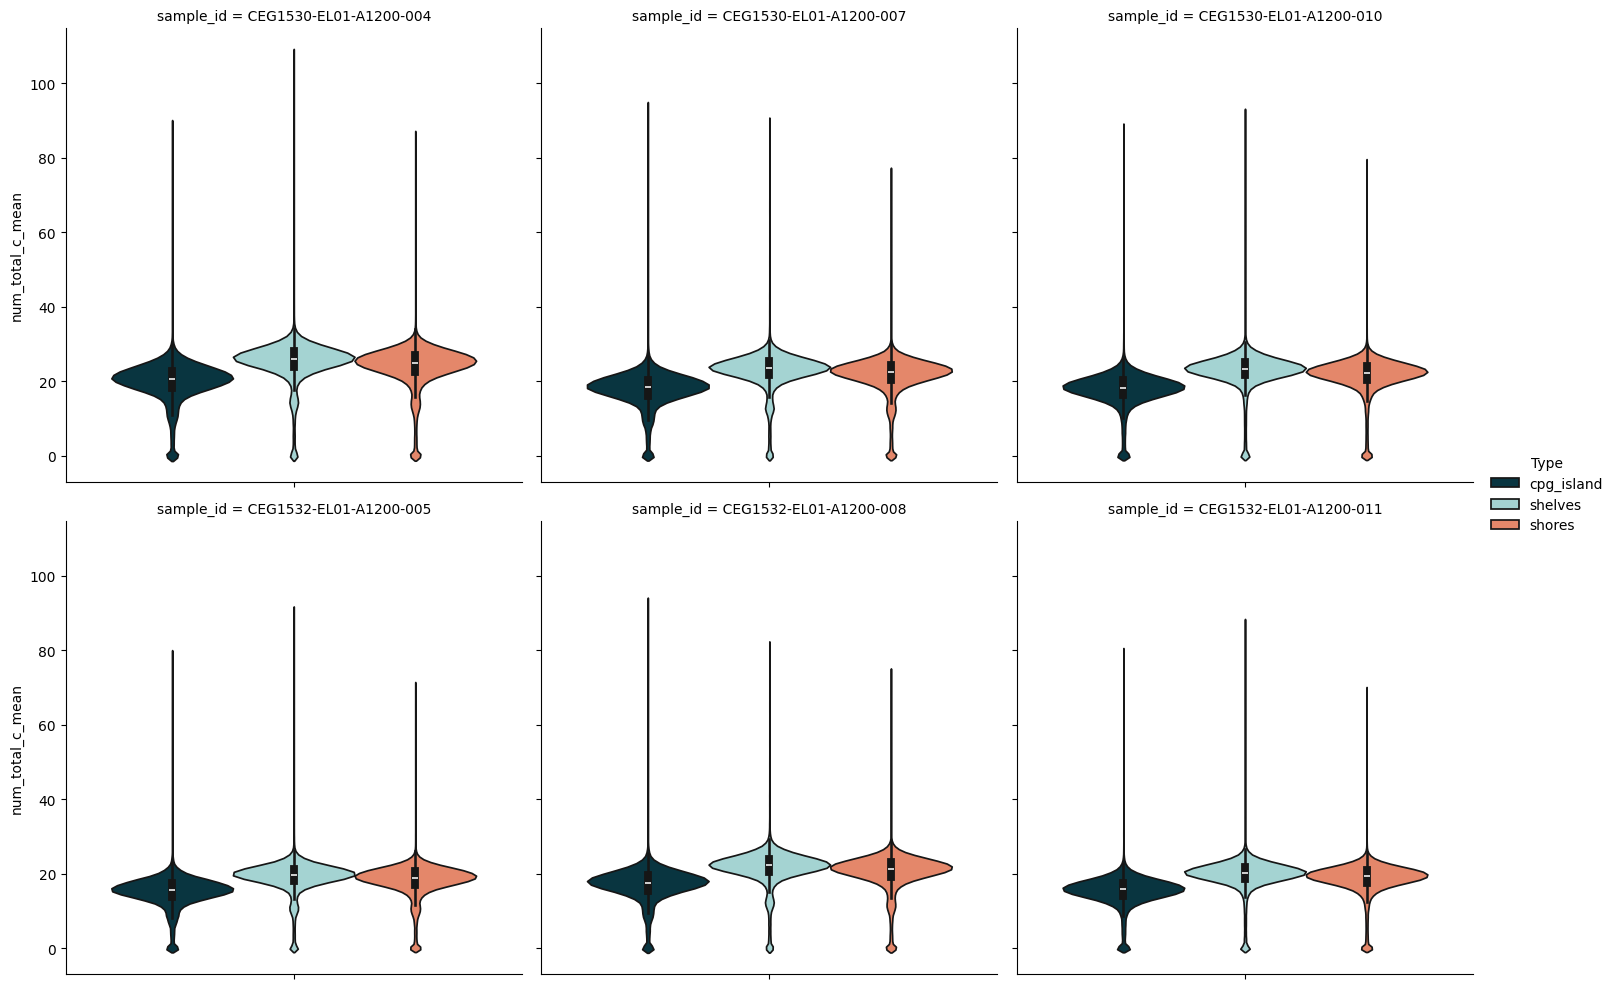

In [12]:
catplot(
    reduced_ds,
    col="sample_id",
    y="num_total_c_mean",
    hue="Type",
    kind="violin",
    col_wrap=3,
)

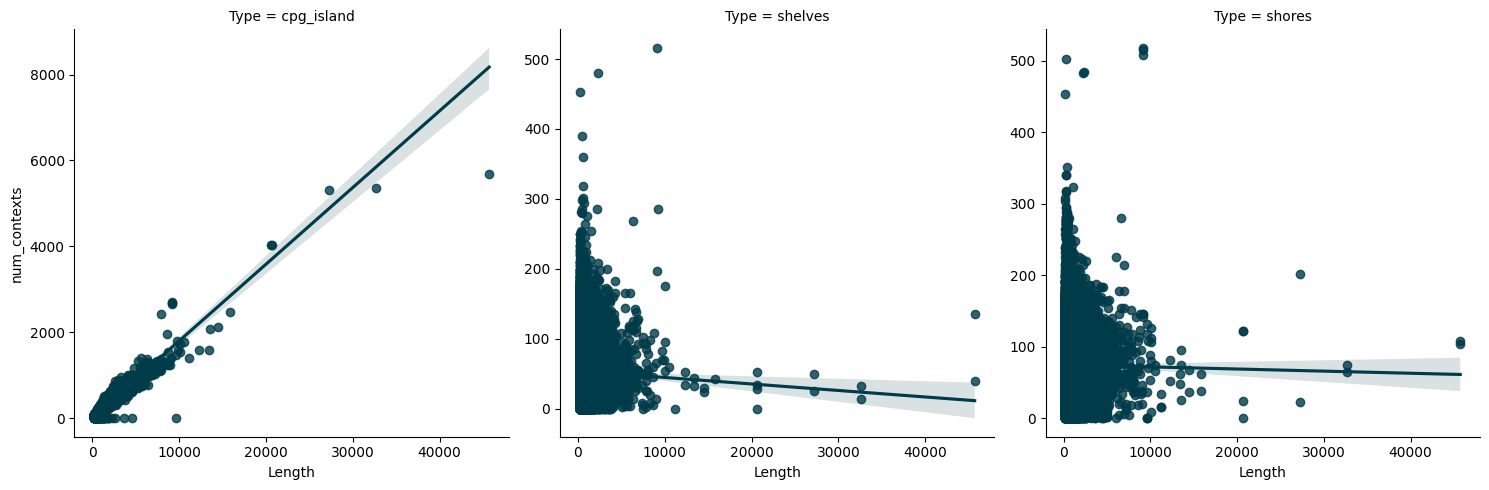

In [13]:
lmplot(reduced_ds, x="Length", y="num_contexts", col="Type", sharey=False)

## Worked example: Comparing exons to 5-prime UTRs

As another example, we can quickly reduce the dataset over exons and 5-prime UTRs and compare the methylation fractions between these two classes:

In [14]:
exons_range = get_exons(
    contig="chr1",
).unstrand()

five_prime_utr_range = get_five_prime_utrs(
    contig="chr1",
).unstrand()

In [15]:
exons_utrs_reduced = ds.reduce_byranges(
    ranges=[exons_range, five_prime_utr_range],
    var="frac_modc",
)
exons_utrs_reduced

<xarray.Dataset>
Dimensions:                   (ranges: 68925, sample_id: 6)
Coordinates:
    contig                    (ranges) <U5 'chr1' 'chr1' ... 'chr1' 'chr1'
    start                     (ranges) int64 65418 65519 ... 248858917 248859014
    end                       (ranges) int64 65432 65572 ... 248859084 248859084
    range_id                  (ranges) int64 0 1 2 3 ... 68921 68922 68923 68924
    num_contexts              (ranges) int64 0 0 36 299 299 16 ... 10 0 0 38 20
    range_length              (ranges) int64 14 53 2548 1025 ... 11 11 167 70
    NA_id                     (sample_id) object 'NA24385' ... 'NA24143'
    giab_id                   (sample_id) object 'HG002' 'HG003' ... 'HG004'
  * sample_id                 (sample_id) <U22 'CEG1530-EL01-A1200-004' ... '...
Dimensions without coordinates: ranges
Data variables:
    frac_modc_sum             (ranges, sample_id) float64 dask.array<chunksize=(17232, 3), meta=np.ndarray>
    frac_modc_mean            (ranges, sample_id) float64 dask.array<chunksize=(17232, 3), meta=np.ndarray>
    frac_modc_cpg_count       (ranges, sample_id) uint64 dask.array<chunksize=(17232, 3), meta=np.ndarray>
    Source                    (ranges) object 'HAVANA' 'HAVANA' ... 'HAVANA'
    Type                      (ranges) object 'exon' 'exon' ... 'five_prime_UTR'
    Score                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Phase                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Id                        (ranges) object 'exon:ENST00000641515.2:1' ... ...
    Parent                    (ranges) object 'ENST00000641515.2' ... 'ENST00...
    Gene_id                   (ranges) object 'ENSG00000186092.7' ... 'ENSG00...
    Transcript_id             (ranges) object 'ENST00000641515.2' ... 'ENST00...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'OR4F5' 'OR4F5' ... 'ZNF692'
    Transcript_type           (ranges) object 'protein_coding' ... 'protein_c...
    Transcript_name           (ranges) object 'OR4F5-201' ... 'ZNF692-202'
    Exon_number               (ranges) object '1' '2' '3' '1' ... '2' '1' '1'
    Exon_id                   (ranges) object 'ENSE00003812156.1' ... 'ENSE00...
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Transcript_support_level  (ranges) object '' '' '' '5' ... '1' '1' '1' '1'
    Tag                       (ranges) object 'RNA_Seq_supported_partial,basi...
    Havana_transcript         (ranges) object 'OTTHUMT00000003223.4' ... 'OTT...
    Hgnc_id                   (ranges) object 'HGNC:14825' ... 'HGNC:26049'
    Ont                       (ranges) object '' '' '' '' '' ... nan nan nan nan
    Havana_gene               (ranges) object 'OTTHUMG00000001094.4' ... 'OTT...
    Protein_id                (ranges) object 'ENSP00000493376.2' ... 'ENSP00...
    Ccdsid                    (ranges) object 'CCDS30547.2' ... 'CCDS53487.1'

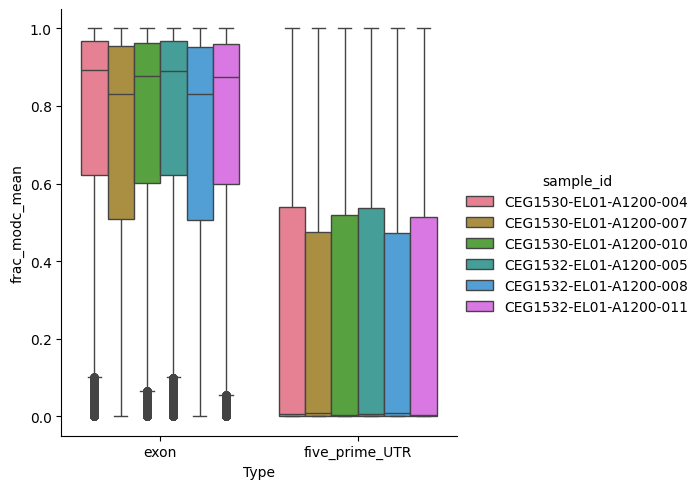

In [16]:
catplot(
    exons_utrs_reduced,
    kind='box',
    hue='sample_id',
    y='frac_modc_mean',
    x='Type',
)

## Subsetting the dataset based on genomic ranges
As well as reducing the dataset over a series of ranges, ```modality``` also supports subsetting the dataset, such that only CpGs that fall within a series of ranges are retained for downstream analysis. This can be very useful to restrict analyses to key regions for example. To do this we can use the ```subset_byranges()``` method of the [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset). Below we use this along with a pca analysis (leveraging [```modality.pca```](https://modality-docs.biomodal.com/modality.html#modality-pca-module)) to demonstrate this functionality and how one might use it:

In [17]:
from modality.pca import run_pca, plot_pca_scatter

In [18]:
islands_ds = ds.subset_byranges(
    ranges=cpg_islands,
)
islands_ds

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint16 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint16 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    num_other                       (pos, sample_id) uint16 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    num_total                       (pos, sample_id) uint16 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint16 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    frac_modc                       (pos, sample_id) float64 dask.array<chunksize=(100000, 6), meta=np.ndarray>
    Protocol Version                (sample_id) object '5-Letter v2.4' ... '5...
    family                          (sample_id) object 'Ashkenazi Jewish' ......
    family_status                   (sample_id) object 'Son' ... 'Mother'
    sex                             (sample_id) object 'Male' ... 'Female'
    tech_replicate_number           (sample_id) int64 1 1 1 2 2 2
    Input DNA Quantity (ng/sample)  (sample_id) int64 80 80 80 80 80 80, coords=Coordinates:
    NA_id         (sample_id) object 'NA24385' 'NA24149' ... 'NA24149' 'NA24143'
    giab_id       (sample_id) object 'HG002' 'HG003' 'HG004' ... 'HG003' 'HG004'
    group         (sample_id) <U22 'CEG1530-EL01-A1200-004' ... 'CEG1532-EL01...
  * sample_id     (sample_id) <U22 'CEG1530-EL01-A1200-004' ... 'CEG1532-EL01...
    contig        (pos) <U5 dask.array<chunksize=(100000,), meta=np.ndarray>
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>, attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'], 'coordinate_basis': 0, 'description': 'A +modC dataset of human Genome in a bottle (GIAB) samples.\nThese data were generated by biomodal using a commercial kit.\n\nEach of the seven GIAB samples were sequenced on a single lane of a NovaSeq S4 flowcell.\nTwo technical replicates are available for each sample.', 'fasta_path': 'GRCh38Decoy-ss-ctrls-v23.fa.gz', 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10, 'input_path': ['CEG1530-EL01-A1200-001.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-004.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-007.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-010.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-013.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-016.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1530-EL01-A1200-019.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-002.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-005.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-008.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-011.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-015.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-017.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1532-EL01-A1200-020.genome.GRCh38Decoy.dedup.duet-modC.CG_quant.tsv.gz'], 'quant_type': 'quant5L', 'ref_name': 'GRCh38Decoy', 'sample_ids': ['CEG1530-EL01-A1200-001', 'CEG1530-EL01-A1200-004', 'CEG1530-EL01-A1200-007', 'CEG1530-EL01-A1200-010', 'CEG1530-EL01-A1200-013', 'CEG1530-EL01-A1200-016', 'CEG1530-EL01-A1200-019', 'CEG1532-EL01-A1200-002', 'CEG1532-EL01-A1200-005', 'CEG1532-EL01-A1200-008', 'CEG1532-EL01-A1200-011', 'CEG1532-EL01-A1200-015', 'CEG1532-EL01-A1200-017', 'CEG1532-EL01-A1200-020'], 'slice_chr1': slice(0, 388278, 1), 'slice_chr10': s

In [19]:
pca_object, transformed_data = run_pca(
    input_array=islands_ds.frac_modc,
)

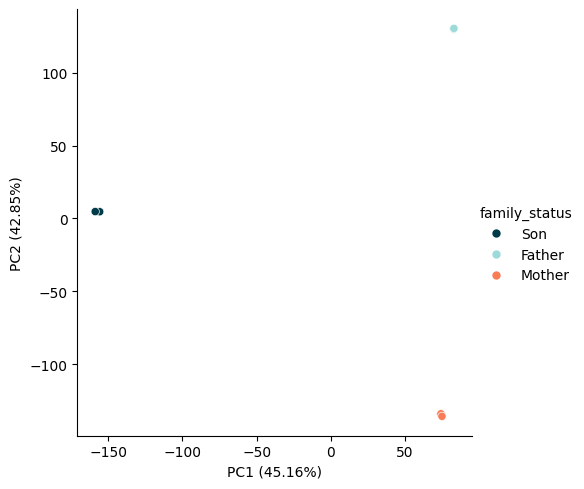

In [20]:
plot_pca_scatter(
    pca_object=pca_object,
    pca_result=transformed_data,
    hue=islands_ds.family_status,
)